In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
# from numpy import argmax
import pandas as pd
import seaborn as sns

In [2]:
import numpy as np

Загружаем данные MNIST. Получаем 60000 train+10000 test ч/б изображений размером 28x28

In [3]:
(x_train, y_train), (x_test, y_test0) = tf.keras.datasets.mnist.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# from numpy.random import choice

In [5]:
# Выведем для примера 9 случайных картинок
spisok = choice(60001, 9, replace=False)
spisok

array([40321,  9003,  7216, 13588,  9462, 18166,  8422, 43646, 38153])

In [37]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add a subplot to the current figure.
    
    Wrapper of `.Figure.add_subplot` with a difference in behavior
    explained in the notes section.
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as
       

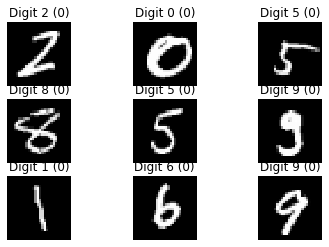

In [6]:
for i in range(len(spisok)):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.title("Digit {0} ({1})".format(y_train[spisok[i]], 0))
    plt.imshow(x_train[spisok[i]], cmap="gray")

plt.subplots_adjust(wspace=0.5)
plt.show()

нормализуем данные:
1. массивы с картинками X приведем к диапазону от 0 до 1, поделив все данные на 255 и затем приведем к типу float 
2. массивы с ответами y приведем к one-hot выборке, заменив одно категориальное значение 10ью бинарными, копию y_test оставим также в первоначальном десятичном виде, чтобы потом построить матрицу confusion для визуализации heatmap

In [4]:
# Так как будем использовать сверточную сеть cnn, а она на вход принимает именно матрицу, а не вектор
# то reshape не делаем, если бы использовали обычную нейронную сеть, нужно было бы сделать 
# reshape(-1,28*28)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /=255
x_test /=255
# y_train = tf.keras.utils.to_categorical(y_train)
# y_test = tf.keras.utils.to_categorical(y_test0)

Моделируем и компилируем сверточную сеть CNN.

In [5]:
conv_model = tf.keras.models.Sequential()
conv_model.add(tf.keras.layers.Convolution2D(32, (3,3), input_shape=(28,28,1), activation='relu'))
conv_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

conv_model.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
conv_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

conv_model.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
conv_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

conv_model.add(tf.keras.layers.Flatten())
conv_model.add(tf.keras.layers.Dense(64, activation = "relu"))
conv_model.add(tf.keras.layers.Dense(10, activation = "softmax"))
conv_model.summary()

# данная loss функция требует чтобы метки были не one-hot-encoding а как индексы класса, то есть
# без преобразования to_categorical
conv_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# conv_model.compile(
#  optimizer = "adadelta",
#  loss = "categorical_crossentropy",
#  metrics = ["accuracy"]
# )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
____

метод summary выводит на структуру модели и количество параметров. В данном случае оно равно 60,554

запускаем обучение и выводим результаты loss и accuracy на графике в зависимости от количества эпох

In [17]:
help(conv_model.evaluate)

Help on method evaluate in module tensorflow.python.keras.engine.training:

evaluate(x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) method of tensorflow.python.keras.engine.sequential.Sequential instance
    Returns the loss value & metrics values for the model in test mode.
    
    Computation is done in batches.
    
    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset or a dataset iterator.
          - A generator or `keras.utils.Sequence` instance.
        y: Target data. Like the input data `x`,
          it could b

In [7]:
y_test = y_test0

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 101s 2ms/sample - loss: 0.2321 - acc: 0.9284 - val_loss: 0.1017 - val_acc: 0.9680
Epoch 2/5
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0770 - acc: 0.9769 - val_loss: 0.0587 - val_acc: 0.9828
Epoch 3/5
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0540 - acc: 0.9836 - val_loss: 0.0644 - val_acc: 0.9816
Epoch 4/5
60000/60000 [==============================] - 349s 6ms/sample - loss: 0.0436 - acc: 0.9868 - val_loss: 0.0615 - val_acc: 0.9825
Epoch 5/5
60000/60000 [==============================] - 93s 2ms/sample - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0466 - val_acc: 0.9867


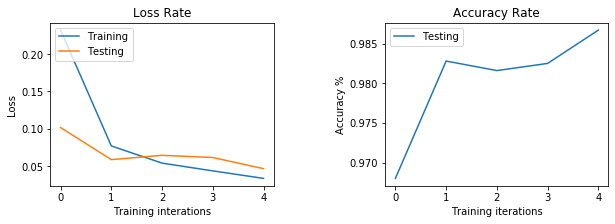

In [8]:
# initial_epoch=11,
hist = conv_model.fit(x_train,y_train, epochs=5,
#                       validation_data=(x_test,y_test)
                      validation_data=(x_test,y_test)
                     )
scores = conv_model.evaluate(x_test, y_test, verbose=0)
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate')
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Testing'], loc='upper left')
# plt.show()
plt.subplot(1, 2, 2)
plt.plot(hist.history['val_acc'])
plt.title('Accuracy Rate')
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')

plt.subplots_adjust(wspace=0.5)
plt.show()

выводим значения loss - функции и точность

In [9]:
# scores = conv_model.evaluate(x_test, y_test, verbose=0)
print("loss={}; accuracy={}".format(hist.history['val_loss'][-1],hist.history['val_acc'][-1]))

loss=0.046611317451891954; accuracy=0.9866999983787537


построим confusion матрицу и отобразим ее с помощью heatmap, для этого предскажем классы для тестовых значений

In [10]:
test_submission = conv_model.predict_classes(x_test, verbose = 1)

10000/10000 [==============================] - 6s 648us/sample


In [11]:
# маркировка классов, нужна для построения матрицы
classes=[0,1,2,3,4,5,6,7,8,9]

In [12]:
con_mat = tf.math.confusion_matrix(labels=y_test0, predictions=test_submission)
# для tf версии 2.0 можно преобразовать данные в numpy массив через .numpy()
sess = tf.Session()
with sess.as_default(): 
    con_mat = con_mat.eval()
# нормализуем матрицу, чтобы выводить долю T/F предсказаний, а не количество
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
con_mat_df

,0,1,2,3,4,5,6,7,8,9
0,0.97,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
1,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.0,0.96,0.01,0.00,0.00,0.00,0.02,0.00,0.00
3,0.00,0.0,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.0,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00
5,0.00,0.0,0.00,0.01,0.00,0.99,0.00,0.00,0.00,0.00
6,0.00,0.0,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00
7,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00
8,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.00
9,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99


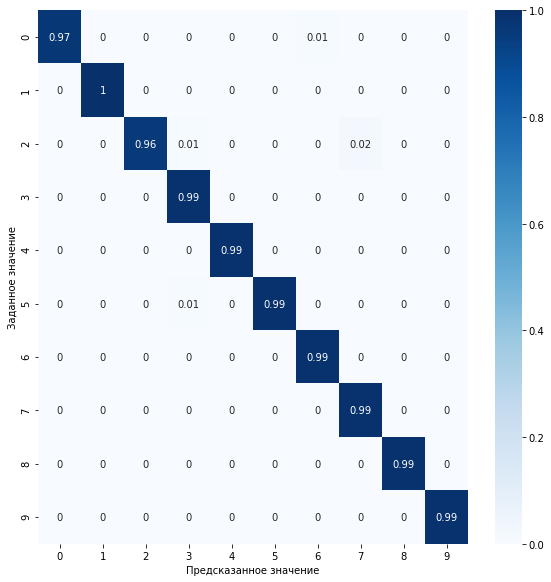

In [13]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Заданное значение')
plt.xlabel('Предсказанное значение')
plt.show()